# Constant pH molecular dynamics in MS$\lambda$D framework

<div class="alert alert-block alert-info">
    <h3> <b>Note 1:</b> In this tutorial, we will use pyCHARMM with BLaDE and pyALF. Therefore, a GPU with CUDA is required. </h3>
</div>
   
<div class="alert alert-block alert-info">
    <h3> <b>Note 2:</b> If you are using SLURM to request one GPU, make sure you have "SBATCH --cpus-per-task=1". We can only have one OpenMP thread to run BLaDE. </h3>
</div>


<div class="alert alert-block alert-info">    
    <h3> <b>Note 3:</b> This tutorial is to provide a simple example of how to perform CpHMD simulations using the MS$\lambda$D framework. It's NOT a toolbox that can be applied to study any protein system yet. We are actively working on this... </h3>
</div>
    

## Introduction

### The objective of this tutorial is to illustrate how to perform constant pH molecular dynamics (CpHMD) simulations using MS$\lambda$D. We will learn:
- ### The physical principle behind CpHMD
- ### How to set up a CpHMD simulation for model compound: Lys in water
- ### How to set up a CpHMD simulation for a peptide: KAAE
- ### Analysis of the simulation results: get titration curve and pKa
- ### Remarks about advanced techniques

## (1) The physical principle behind CpHMD

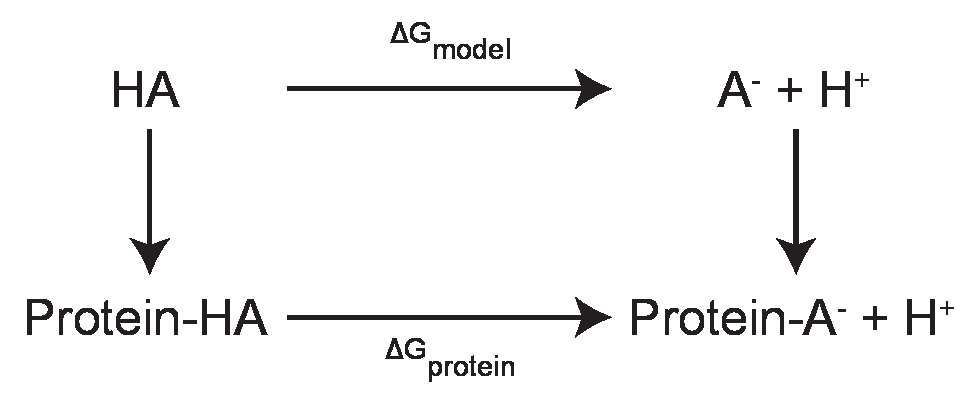



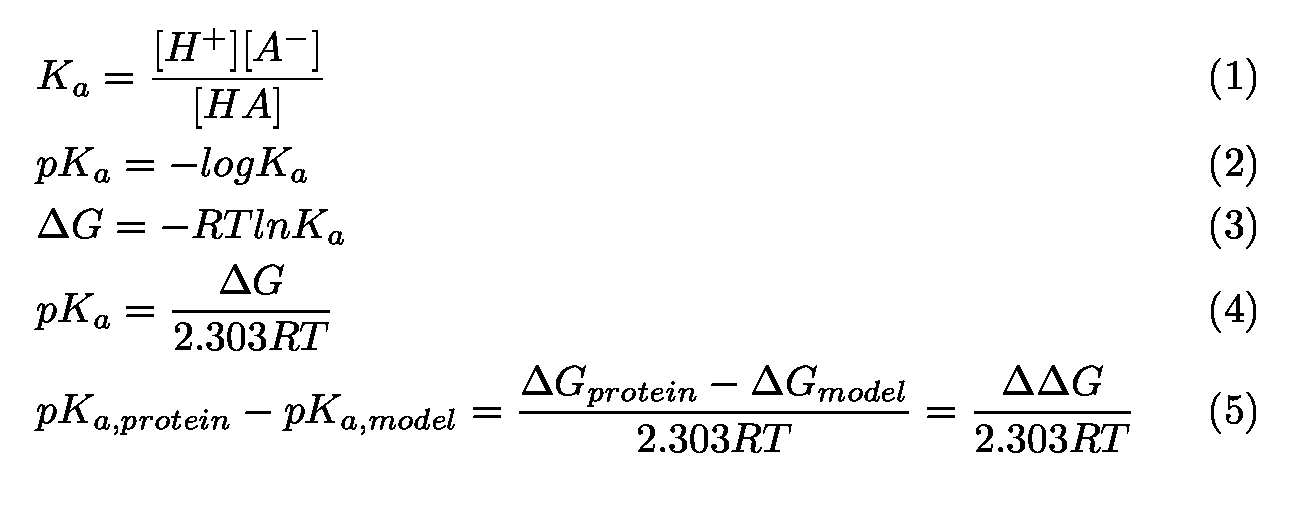




### According to Eq. 5, if we know the $pK_a$ of model compound, we can use $\Delta\Delta G=\Delta G_{protein}-\Delta G_{model}$ to compute the $pK_a$ of a titratable group in the protein environment. Here we assume that the non-MM part (i.e., quantum effects that can not be described by molecular mechanics) of $\Delta G_{model}$ and $\Delta G_{protein}$ is the same for both legs.

### The potential energy of the system in MS$\lambda$D is as follows. Here, the purpose of using $V_{bias}(\{\lambda\})$ is to flatten the alchemical free energy landscape, such that we can get sufficient sampling of all end states. For instance, for a Lys dipeptide in water, if $V_{bias}(\{\lambda\})$ is the negative of corresponding potential of mean force (PMF), we can obtain effcient sampling in alchemical space in MS$\lambda$D simulations.

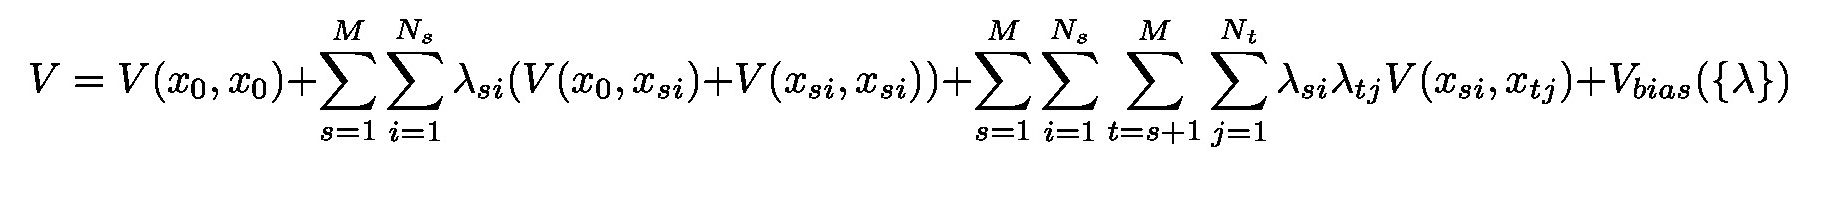

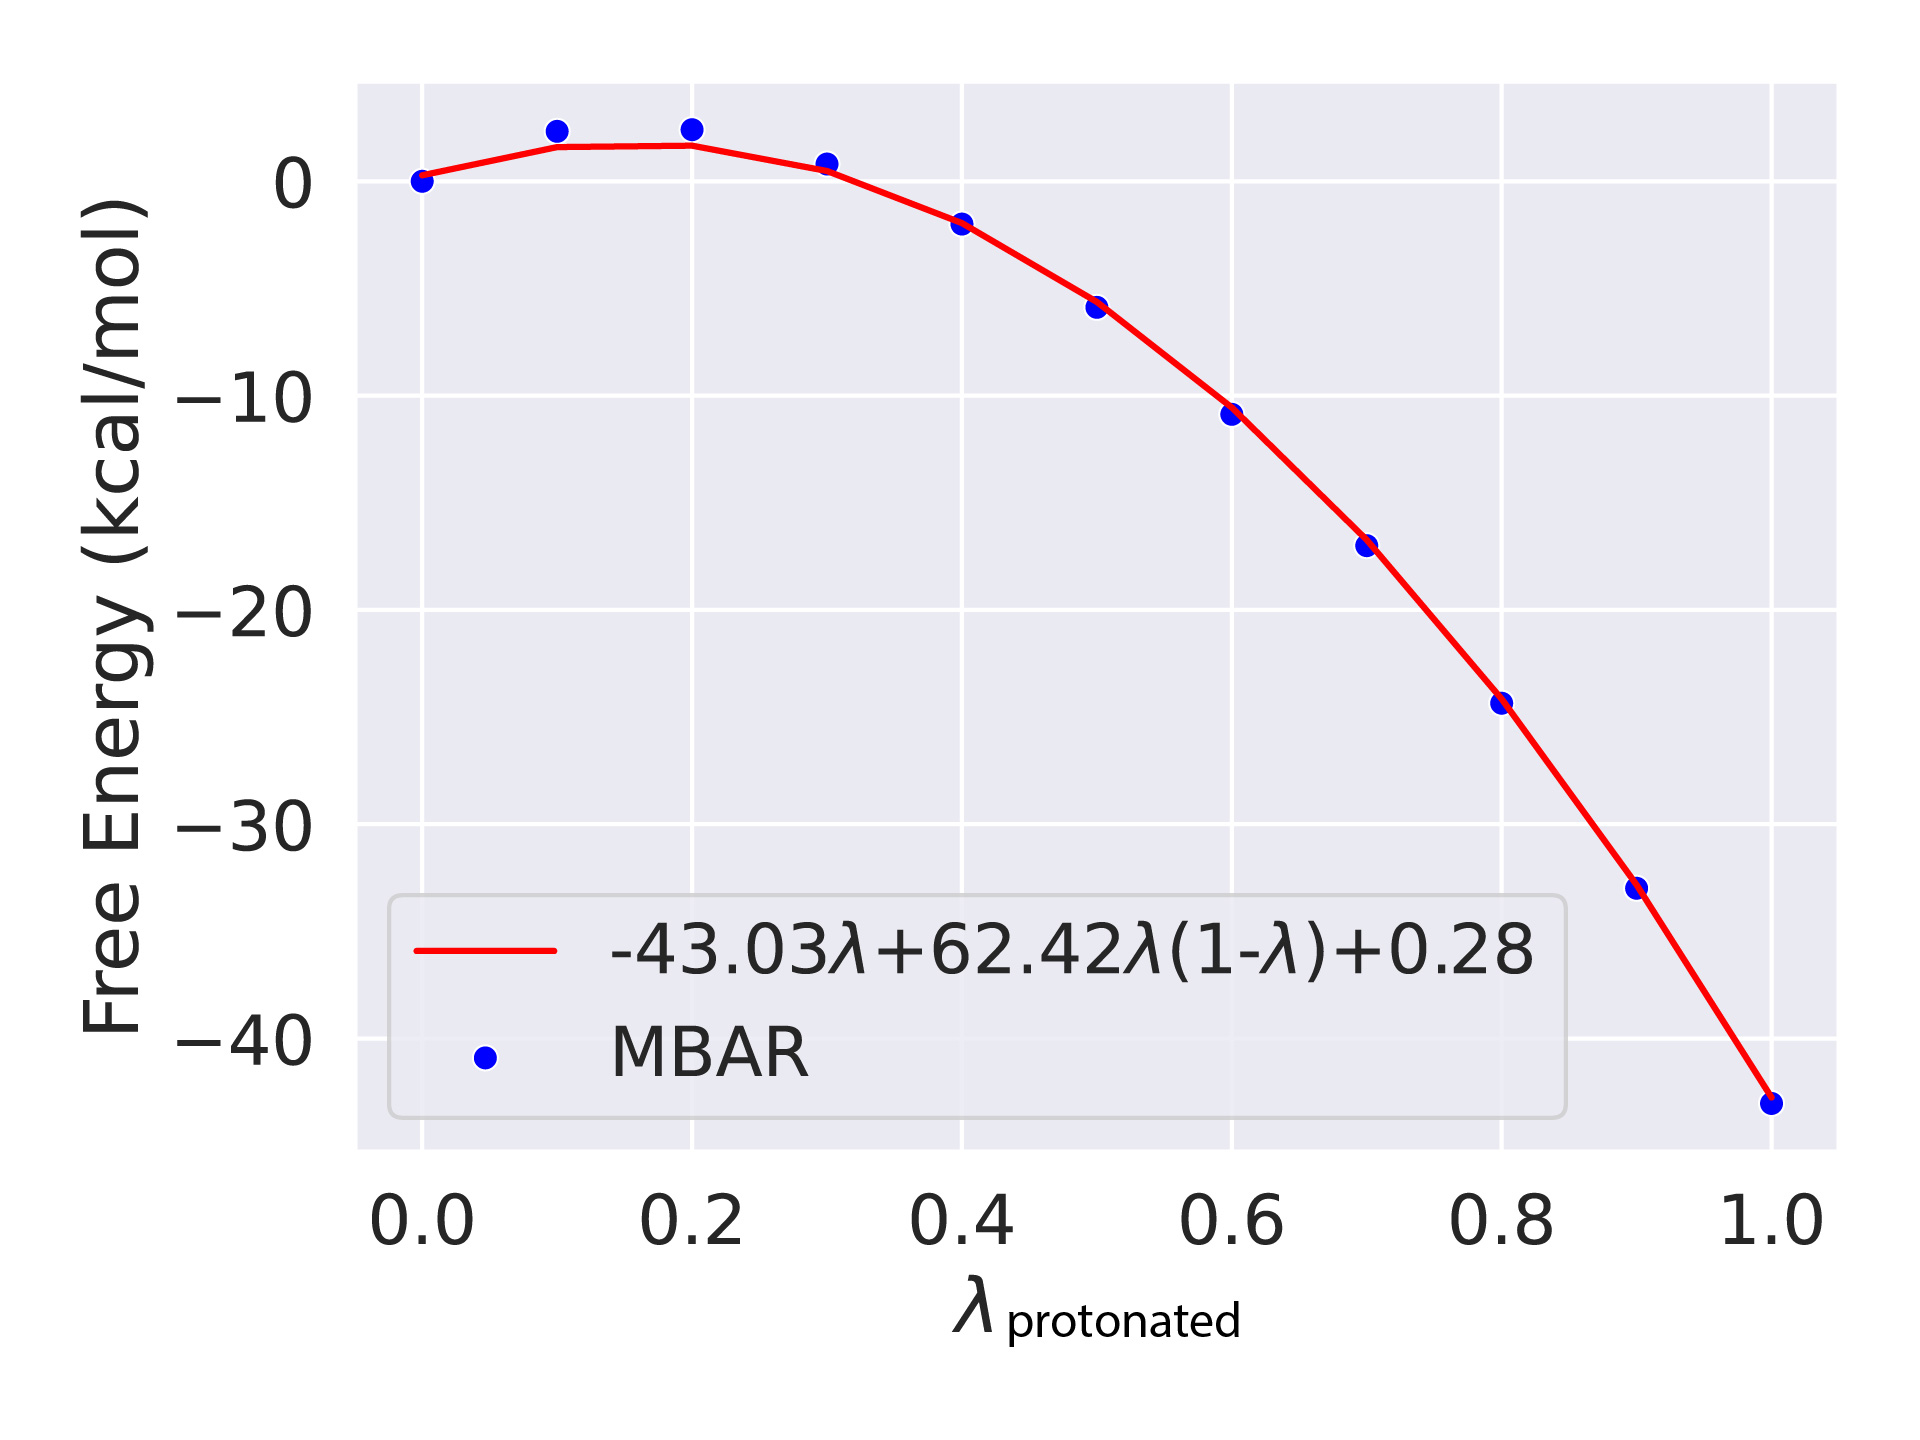

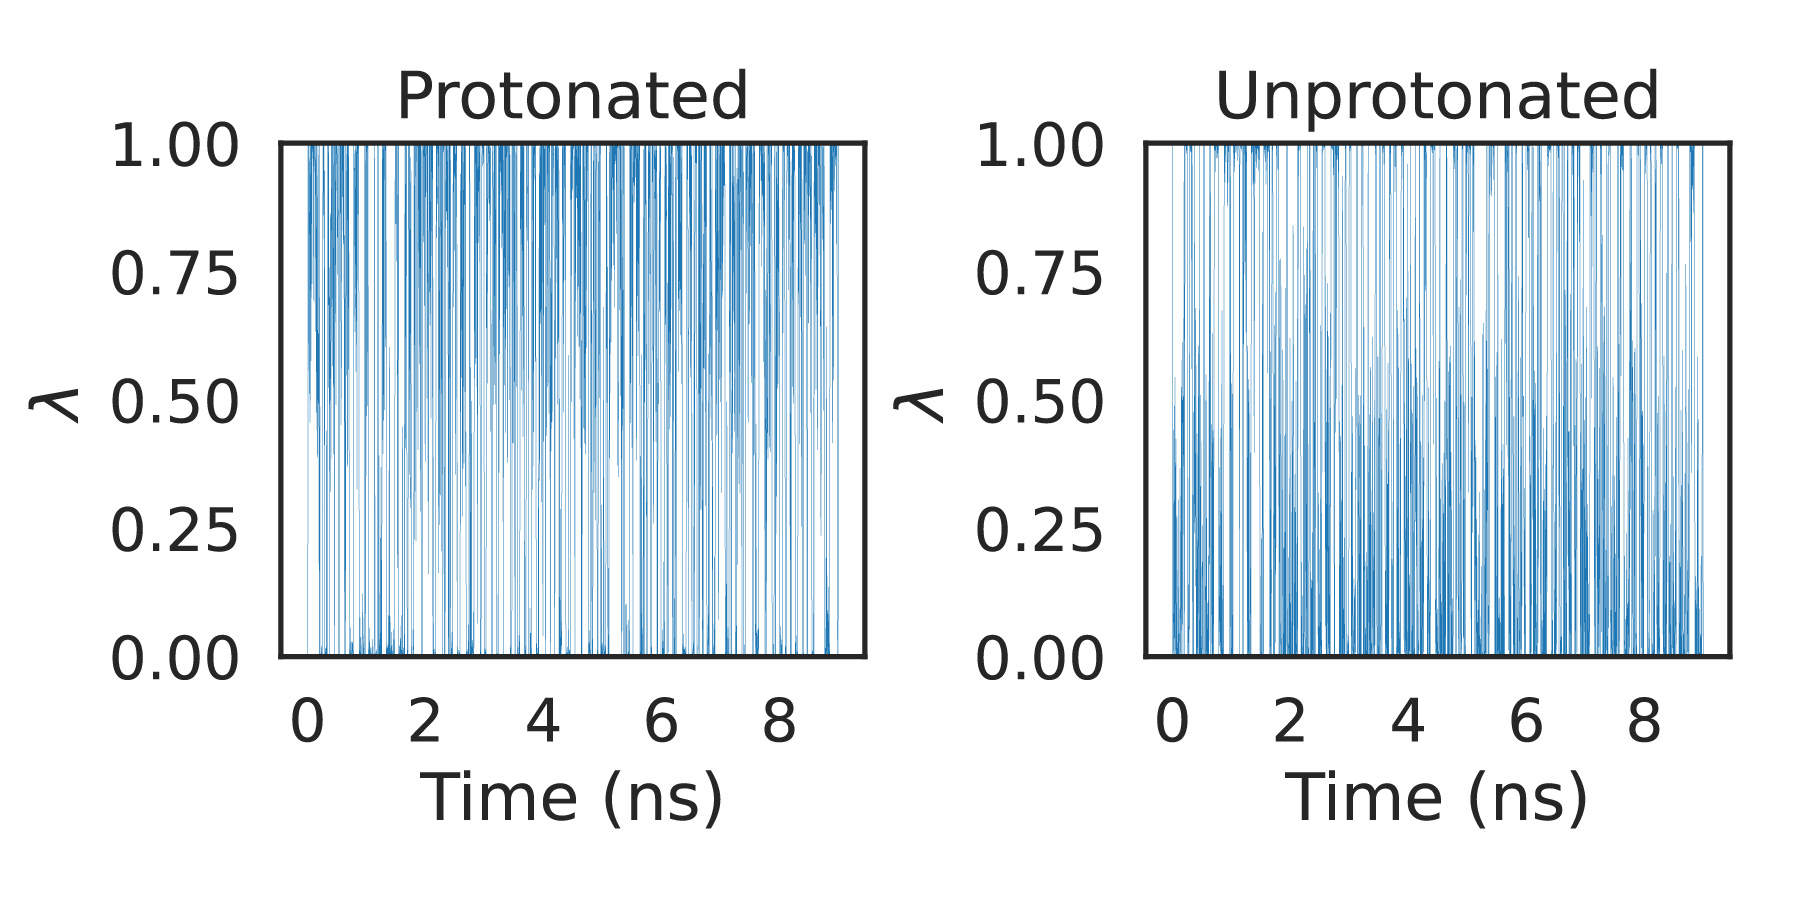

### The goal of ALF is to obtain optimal $V_{bias}(\{\lambda\})$ using short trial simulations. In MS$\lambda$D framework, there are four types of biasing potential so far. In CpHMD, two of them are more important, the fixed term $V_{fixed}(\{\lambda\})$, and the quadratic term $V_{quadratic}(\{\lambda\})$. The linear term $V_{fixed}(\{\lambda\})$ is to make the free energies of different protonation states the same, and the quadratic term $V_{quadratic}(\{\lambda\})$ is to lower the free energy barrier between different protonation states and it doesn't perturb the end states.

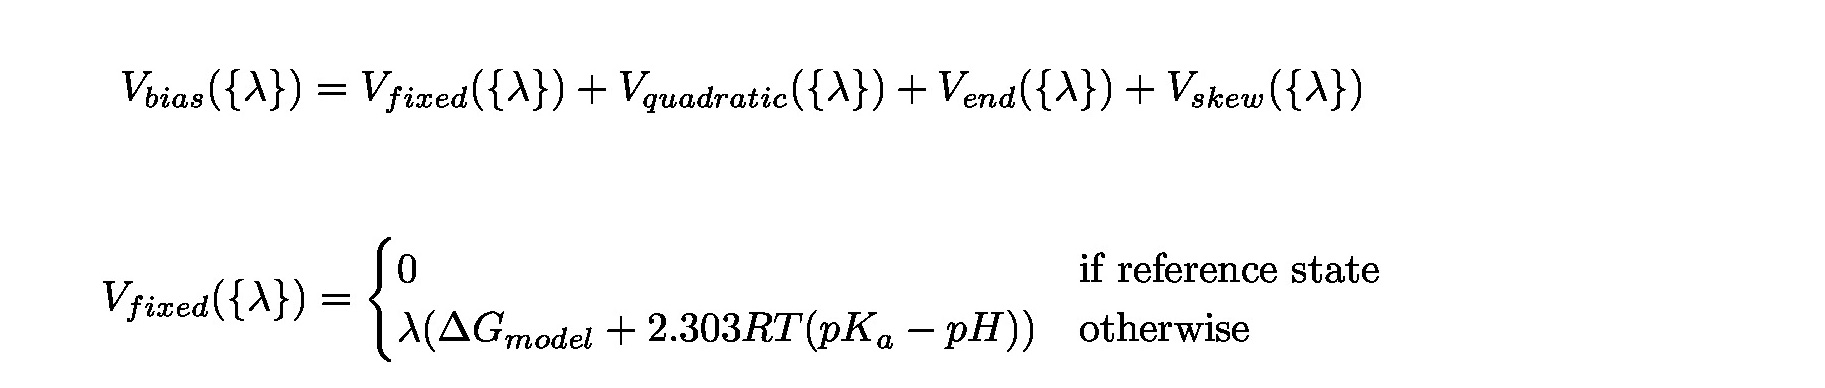

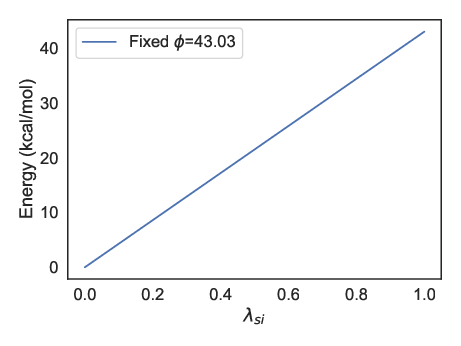

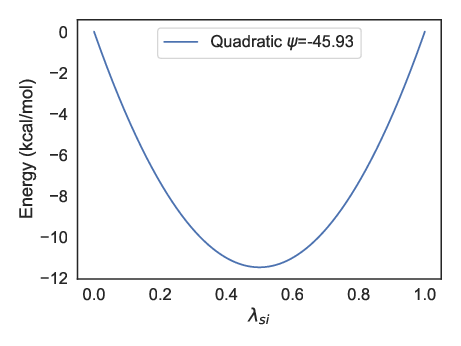

## (2) How to build a hybrid system 

### A separate script will be provided to illustrate how to build a hybrid system where there are multiple protonation states for each titratable residue of a given protein. Below is a Lys dipeptide in hybrid state ($\color{red}{\text {red: unprontonated}}$; $\color{blue} {\text {blue: protonated}}$).

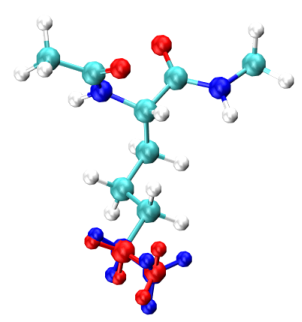

### As shown below, we modified the atom names by adding one more letter to denote the protonation state. For instance, for Lys, $W$ is for the protonated state, and $M$ is for the unprotonated state. This will be useful later when we need to define a selection and assign it to a BLOCK.

In [ ]:
!grep 'LYS' kaae/kaae-mini.pdb

## (3) Set up a CpHMD simulation for model compound: Lys in water

### (3.1) Use ALF to obtain optimal $V_{bias}(\{\lambda\})$

#### Here, we will simulate a Lys dipeptide in water $\color{red} {\text{with $pH$ equal to its experimental $pK_a$ }}$. ALF will be used to optimize the biasing potential $V_{bias}(\{\lambda\})$. Based on the above equation, we can see that when $pH = pK_a$, the pH dependent term in $V_{fixed}(\{\lambda\})$ is zero. To obtain equal population of protonated and unprotonated states, parameters of $V_{fixed}(\{\lambda\})$ obtained from ALF should reflect the pronation free energy of Lys in water (i.e., $\Delta G_{model}$).

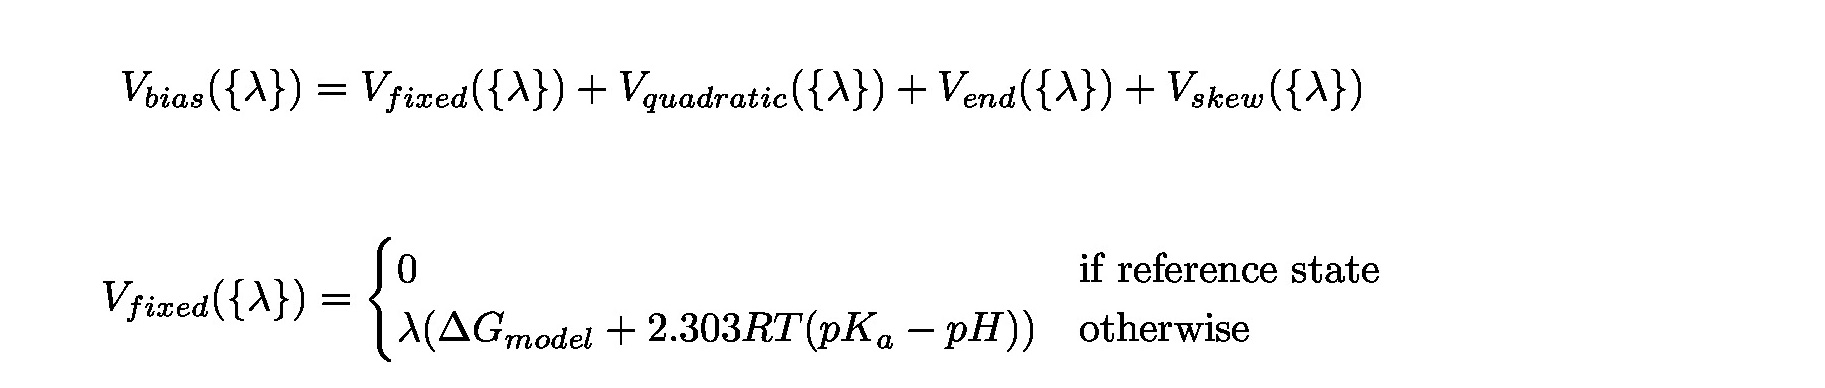

In [ ]:
# import pycharmm and other necessary modules
import os
import sys
import subprocess
import numpy as np
import pandas as pd
import shlex
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import pickle 

import alf
from alf.GetLambda import GetLambda
import shutil

import pycharmm
import pycharmm.read as read
import pycharmm.lingo as lingo
import pycharmm.generate as gen
import pycharmm.settings as settings
import pycharmm.write as write
import pycharmm.nbonds as nbonds
import pycharmm.ic as ic
import pycharmm.coor as coor
import pycharmm.energy as energy
import pycharmm.dynamics as dynb
import pycharmm.minimize as minimize
import pycharmm.crystal as crystal
import pycharmm.select as select
import pycharmm.image as image
import pycharmm.psf as psf
import pycharmm.param as param
import pycharmm.cons_harm as cons_harm
import pycharmm.cons_fix as cons_fix
import pycharmm.shake as shake
import pycharmm.scalar as scalar
import pycharmm.charmm_file as charmm_file


#### Environmental variables `CHARMM_LIB_DIR` and `ALF_SOURCE_DIR` need to be defined before running this script

In [ ]:
CHARMM_LIB_DIR = '/home/xrliu/program/charmm/stable/charmm-compile/build_pycharmm/install/lib'
if os.getenv('CHARMM_LIB_DIR') == None:
    os.environ['CHARMM_LIB_DIR'] = CHARMM_LIB_DIR
print(os.getenv('CHARMM_LIB_DIR'))


ALF_SOURCE_DIR = '/home/xrliu/program/ALF'
if os.getenv('ALF_SOURCE_DIR') == None:
     os.environ['ALF_SOURCE_DIR'] = ALF_SOURCE_DIR
print(os.getenv('ALF_SOURCE_DIR'))

#### The following variables need to be defined to reflect information of the system. A particularly important file is prep/alf_info.py. We need to manually modify this file for a given system. The information in this file will be used by ALF and this tutorial.

In [ ]:
comp='lys'    # system name

segid='PROT'   # segment ID for the peptide

param_dir='./toppar_c36_jul21' # force field parameter directory
wrk_dir=f'./{comp}'      # working directory



# The following information is from file prep/alf_info.py
cwd=os.getcwd()
os.chdir(wrk_dir)
if not os.path.exists('prep/alf_info.py'):
    print('ERROR: File prep/alf_info.py not found!!')
alf_info=alf.initialize_alf_info(engine='pycharmm')
os.chdir(cwd)

name=alf_info['name']
nblocks=alf_info['nblocks']
nsubs=alf_info['nsubs']
nsites=len(alf_info['nsubs'])
nreps=alf_info['nreps']
nnodes=alf_info['nnodes']
ncentral=alf_info['ncentral']
tsim=alf_info['temp']         # simulation temperature


In [ ]:
os.system(f'cat {wrk_dir}/prep/alf_info.py')

In [ ]:
log_unit=30  # unit for CHARMM output file
dcd_unit=40  # unit for dcd trajectory file
rst_unit=50  # unit for restart file
lmd_unit=60  # unit for lambda trajectory file
rpr_unit=70  # unit for previous restart file

# experimental pKa for model compound
pka={'ASP':4.0,
     'GLU':4.4,
     'HSD':7.0,
     'HSE':6.6,
     'LYS':10.40}

In [ ]:
def find_titr_res():
    '''
    Find all titratable residues in a PDB structure.
    
    Return
    ------
    titr_res_dict : dict 
             a dictionary to reflect all titratable residues in a system.
             Keys are residue names, like LYS, ASP, GLU. 
             Values are list of two lists: the first list contains residue IDs; the second list contains residue index.
    '''
    sele_ca=pycharmm.SelectAtoms(atom_type='CA')
    sele_asp=pycharmm.SelectAtoms(res_name='ASP')
    sele_glu=pycharmm.SelectAtoms(res_name='GLU')
    sele_hsp=pycharmm.SelectAtoms(res_name='HSP')
    sele_hsd=pycharmm.SelectAtoms(res_name='HSD')
    sele_hse=pycharmm.SelectAtoms(res_name='HSE')
    sele_lys=pycharmm.SelectAtoms(res_name='LYS')
    sele_ca_asp=sele_ca & sele_asp
    sele_ca_glu=sele_ca & sele_glu
    sele_ca_hsp=sele_ca & ( sele_hsp | sele_hsd | sele_hse )
    sele_ca_lys=sele_ca & sele_lys
    sele_asp_resid=sele_ca_asp.get_res_ids()
    sele_glu_resid=sele_ca_glu.get_res_ids()
    sele_hsp_resid=sele_ca_hsp.get_res_ids()
    sele_lys_resid=sele_ca_lys.get_res_ids()
    sele_asp_resinx=sele_ca_asp.get_res_indexes()
    sele_glu_resinx=sele_ca_glu.get_res_indexes()
    sele_hsp_resinx=sele_ca_hsp.get_res_indexes()
    sele_lys_resinx=sele_ca_lys.get_res_indexes()
    titr_res_dict={'LYS':[sele_lys_resid,sele_lys_resinx],
                   'ASP':[sele_asp_resid,sele_asp_resinx],
                   'GLU':[sele_glu_resid,sele_glu_resinx],
                   'HSP':[sele_hsp_resid,sele_hsp_resinx]}
    #print(titr_res_dict)
    with open(f'{wrk_dir}/titr_res_dict.pkl', 'wb') as f:
        pickle.dump(titr_res_dict, f)
    return titr_res_dict

In [ ]:
def init_variables():
    '''
    A function to initialize biasing potential parameters by setting all parameters to zero.
    '''
    AA=comp[0:3].upper()
    b=np.zeros([1,nblocks])
    c=np.zeros([nblocks,nblocks])
    x=c
    s=c
    b_prev=np.zeros([1,nblocks])
    c_prev=c
    x_prev=x
    s_prev=s
    var_init_dir=wrk_dir+'/analysis0'
    os.system('mkdir -p '+var_init_dir+'/../nbshift')
    np.savetxt(var_init_dir+'/b_prev.dat',b_prev)
    np.savetxt(var_init_dir+'/b.dat',b)
    np.savetxt(var_init_dir+'/c_prev.dat',c_prev)
    np.savetxt(var_init_dir+'/c.dat',c)
    np.savetxt(var_init_dir+'/x_prev.dat',x_prev)
    np.savetxt(var_init_dir+'/x.dat',x)
    np.savetxt(var_init_dir+'/s_prev.dat',s_prev)
    np.savetxt(var_init_dir+'/s.dat',s)
    np.savetxt(var_init_dir+'/../nbshift/b_shift.dat',b_prev)
    np.savetxt(var_init_dir+'/../nbshift/c_shift.dat',c_prev)
    np.savetxt(var_init_dir+'/../nbshift/x_shift.dat',x_prev)
    np.savetxt(var_init_dir+'/../nbshift/s_shift.dat',s_prev)


In [ ]:
def open_clog():
    '''
    specify charmm output file for a given system
    '''
    clog=charmm_file.CharmmFile(file_name=log_fn,file_unit=log_unit,read_only=False,formatted=True)
    lingo.charmm_script('outu '+str(log_unit))

In [ ]:
def read_param():
    '''
    read CHARMM force field parameters.
    note that special RTF file is needed for this tutorial.
    '''
    read.rtf(param_dir+'/top_all36_prot.rtf')
    read.rtf(param_dir+'/cphmd_patch.rtf',append=True)
    read.prm(param_dir+'/par_all36m_prot.prm',flex=True)
    lingo.charmm_script('stream '+param_dir+'/toppar_water_ions.str')

In [ ]:
def read_init(irun=1):
    '''
    read psf and initial structure file
    '''
    read.psf_card(f'{wrk_dir}/{comp}-solv.psf')
    if int(irun)==1:
       read.pdb(f'{wrk_dir}/{comp}-mini.pdb',resid=True)
    else:
       rst_from=np.loadtxt(f'{out_dir}/../variables/rst-from-{irun}.txt',dtype=int)
       read.pdb(f'{out_dir}/../run{rst_from}/pdb/prod.pdb',resid=True)

In [ ]:
def titr_grp(resn):
    '''
    atom names in the titratable group for a given amino acid
    '''
    if resn == 'ASP':
       type_list=['CB','HB1','HB2','CG','OD1','OD2','HD1','HD2']
    elif resn == 'GLU':
       type_list=['CG','HG1','HG2','CD','OE1','OE2','HE1','HE2']
    elif resn == 'HSP' or resn == 'HSD' or resn == 'HSE':
       type_list=['CB','HB1','HB2','CG','ND1','HD1','CE1','HE1','CD2','HD2','NE2','HE2']
    elif resn == 'LYS':
       type_list=['CE','HE1','HE2','NZ','HZ1','HZ2','HZ3']
    return type_list



In [ ]:
def define_sub(titr_res_dict):
    '''
    define substituent in a hybrid system. 
    see the special RTF file for more information.
    
    Parameters
    ----------
    titr_res_dict : dict
             a dictionary to reflect all titratable residues in a system.
             Keys are residue names, like LYS, ASP, GLU. 
             Values are list of two lists: the first list contains residue IDs; the second list contains residue index.
    '''
    for aa in titr_res_dict.keys():
        resn=aa.upper()
        atom_list=titr_grp(resn)
        for ires in titr_res_dict[resn][0]:
            resid=str(ires)
            w_str=' '.join([i+'W' for i in atom_list])
            m_str=' '.join([i+'M' for i in atom_list])
            p_str=' '.join([i+'P' for i in atom_list])
            u_str=' '.join([i+'U' for i in atom_list])
            sele_w=pycharmm.SelectAtoms().by_res_and_type(seg_id=segid,res_id=resid,atom_type=w_str)
            sele_m=pycharmm.SelectAtoms().by_res_and_type(seg_id=segid,res_id=resid,atom_type=m_str)
            sele_p=pycharmm.SelectAtoms().by_res_and_type(seg_id=segid,res_id=resid,atom_type=p_str)
            sele_u=pycharmm.SelectAtoms().by_res_and_type(seg_id=segid,res_id=resid,atom_type=u_str)
            sele_w.store(f'site{resn}{resid}subW')
            sele_m.store(f'site{resn}{resid}subM')
            sele_p.store(f'site{resn}{resid}subP')
            sele_u.store(f'site{resn}{resid}subU')
            lingo.charmm_script(f'print coor sele site{resn}{resid}subW end')
            lingo.charmm_script(f'print coor sele site{resn}{resid}subM end')
            lingo.charmm_script(f'print coor sele site{resn}{resid}subP end')
            lingo.charmm_script(f'print coor sele site{resn}{resid}subU end')
            


#### The following function `setup_block` is to set up BLOCK command for CHARMM usage. For Lys in water, we expect to generate something as follows:

```
BLOCK 3
      call 2 sele siteLYS1subP  end
      call 3 sele siteLYS1subU  end

      excl 2 3

      qldm theta
      lang temp 298.15
      pmel ex
      phmd pH 10.4

      ldin 1  1.0  0.0  12.0  0   5.0  NONE
      ldin 2  0.5  0.0  12.0  0   5.0  NONE
      ldin 3  0.5  0.0  12.0  0   5.0  UPOS   10.4

      rmla bond thet impr
      msld 0 1 1 fnex 5.5
      msma

      ldbi 5
      ! quadratic barrier
      ldbv 1 2 3 6 0.0   -0.0 0
      ! V_endpoint
      ldbv 2 2 3 8 0.017 -0.0 0
      ldbv 3 3 2 8 0.017 -0.0 0
      ! V_skew
      ldbv 4 2 3 10 -5.56 -0.0 0
      ldbv 5 3 2 10 -5.56 -0.0 0

END

```

In [ ]:
class setup_block:
    '''
    Set up block for CpHMD simulation in the MSLD framework.
    '''
    def __init__(self,bias,titr_res_dict,pH=None):
        self.Gbias=bias
        self.titr_res_dict=titr_res_dict
        self.pH=pH
        """
        Parameters
        ----------
        Gbias : pandas.DataFrame
             biasing potential parameters
        titr_res_dict : dictionary
             a dictionary to reflect all titratable residues in a system.
             Keys are residue names, like LYS, ASP, GLU. 
             Values are list of two lists: the first list contains residue IDs; the second list contains residue index, which can be empty.
        pH : float
             pH value under which CpHMD simulation is performed
            
        """
    def run(self):
        """
        reset and run the BLOCK command
        """
        self.reset()
        self.call()
    def set_utag(self,resname):
        """
        Depending on the amino acid and reference state, use either UNEG or UPOS for the pH-dependent term
        """
        if resname == 'ASP' or resname == 'GLU':
           utag='UNEG'
        elif resname == 'HSD' or resname == 'HSE' or resname == 'HSP' or resname == 'LYS':
           utag='UPOS'
        return utag
    def set_name(self,resname,res_id):
        """
        Based on the speicial RTF file, get a list of selection names for a given residue.
        """
        sele_name_w='site%s%ssubW'%(resname,res_id)
        sele_name_m='site%s%ssubM'%(resname,res_id)
        sele_name_p='site%s%ssubP'%(resname,res_id)
        sele_name_u='site%s%ssubU'%(resname,res_id)
        if resname == 'ASP' or resname == 'GLU':
           sele_name=[sele_name_w,sele_name_m,sele_name_p]
        elif resname == 'HSD':
           sele_name=[sele_name_w,sele_name_u]
        elif resname == 'HSE':
           sele_name=[sele_name_w,sele_name_m]
        elif resname == 'LYS':
           sele_name=[sele_name_w,sele_name_m]
        elif resname == 'HSP':
           sele_name=[sele_name_w,sele_name_u,sele_name_m]
        return sele_name
    def set_pka(self,resname):
        if resname == 'HSP':
           refpka_list=[pka['HSD'],pka['HSE']]
        else:
           refpka_list=[pka[resname],pka[resname]]
        return refpka_list
    def reset(self):
        """
        clear BLOCK
        """
        lingo.charmm_script('''
              BLOCK {}
                    clear 
              END
        '''.format(nblocks+1))
    def call(self):
        '''
        Generate a string that will be used by lingo.charmm_script().
        
        note: don't put these commands into multiple block sections.
        otherwise energy can be incorrect in domdec and blade.
        '''

        block_str=f'BLOCK {nblocks+1}\n'
        ldin_str='      !   id lmd vel mass energy friction-coefficient\n'
        ldin_str+='      ldin 1 1.0000  0.0  12.0     0.00  5.0\n'
        msld_str='      msld 0 '

        iblock=2
        isite=0
        for aa in self.titr_res_dict.keys():
            resn=aa.upper()
            for ires in self.titr_res_dict[resn][0]:
                resid=str(ires)
                utag=self.set_utag(resn)
                refpka=self.set_pka(resn)
                sele_name_lst=self.set_name(resn,resid)
                for isub in range(nsubs[isite]):
                    #print(isite,isub)
                    sele_name=sele_name_lst[isub]
                    if isub!=0 and self.pH!=None:
                        phtag=utag+' '+str(refpka[isub-1])
                        
                    else:
                        phtag='NONE'

                    block_str+=f'      call {iblock} sele {sele_name} end\n'
                    ldin_str+='      ldin {} {:.4f}  0.0  12.0  {:7.2f}  5.0  {}\n'.format(iblock,1/nsubs[isite],self.Gbias.loc[f'lams{isite+1}s{isub+1}','value'],phtag)
                    
                    msld_str+=f'{isite+1} '
                    iblock+=1
                isite+=1
        msld_str+='fnex 5.5\n'

        excl_lst='      excl '
        iblock=2
        for isite in range(nsites):
            for isub in range(nsubs[isite]):
                shift=1
                for jsub in range(isub+1,nsubs[isite]):
                    excl_lst+='{} {} '.format(iblock,iblock+shift)
                    shift+=1
                iblock+=1
        excl_lst+='\n'

        nldbi=int(5*nblocks*(nblocks-1)/2)
        ldbi_str='      ldbi {}\n'.format(nldbi)
        ibias=0
        iblock0=2
        for isite in range(nsites):
            jblock0=iblock0
            for jsite in range(isite,nsites):
                for isub in range(nsubs[isite]):
                    iblock=iblock0+isub
                    if jsite==isite:
                       jlow=isub+1
                    else:
                       jlow=0
                    for jsub in range(jlow,nsubs[jsite]):
                        jblock=jblock0+jsub
                        ibias+=1
                        ldbi_str+='      ldbv {:3d} {:3d} {:3d}  6   0.0 {:7.2f} 0\n'.format(ibias,iblock,jblock,self.Gbias.loc[f'cs{isite+1}s{isub+1}s{jsite+1}s{jsub+1}','value'])
                        ibias+=1
                        ldbi_str+='      ldbv {:3d} {:3d} {:3d} 10 -5.56 {:7.2f} 0\n'.format(ibias,iblock,jblock,self.Gbias.loc[f'xs{isite+1}s{isub+1}s{jsite+1}s{jsub+1}','value'])
                        ibias+=1
                        ldbi_str+='      ldbv {:3d} {:3d} {:3d} 10 -5.56 {:7.2f} 0\n'.format(ibias,jblock,iblock,self.Gbias.loc[f'xs{jsite+1}s{jsub+1}s{isite+1}s{isub+1}','value'])
                        ibias+=1
                        ldbi_str+='      ldbv {:3d} {:3d} {:3d}  8 0.017 {:7.2f} 0\n'.format(ibias,iblock,jblock,self.Gbias.loc[f'ss{isite+1}s{isub+1}s{jsite+1}s{jsub+1}','value'])
                        ibias+=1
                        ldbi_str+='      ldbv {:3d} {:3d} {:3d}  8 0.017 {:7.2f} 0\n'.format(ibias,jblock,iblock,self.Gbias.loc[f'ss{jsite+1}s{jsub+1}s{isite+1}s{isub+1}','value'])
                jblock0+=nsubs[isite]
            iblock0+=nsubs[isite]

        soft_str='\n'

        block_str+='\n'
        block_str+=excl_lst
        block_str+='\n'
        block_str+='      qldm theta\n'
        block_str+='      lang temp {}\n'.format(tsim)
        block_str+='      pmel ex\n'
        if self.pH!=None:
            block_str+='      phmd pH {}'.format(self.pH)
        block_str+=soft_str
        block_str+='\n'
        block_str+=ldin_str
        block_str+='\n'
        block_str+='      rmla bond thet impr\n'
        block_str+=msld_str
        block_str+='      msma\n'
        block_str+='\n'
        block_str+=ldbi_str
        block_str+='END\n'

        lingo.charmm_script(block_str)


In [ ]:
# Ensure that FFT grid is product of small primes (2, 3, 5)
def find_prime_prod(n):
    '''
    find a minimum even number that is a product of 2, 3, or 5, and is greater than the given value n
    '''
    n=np.ceil(n)
    find=0
    while find == 0:
          if (n%2 != 0):
             find=0   # we have to find an even number
          else:
             ni=n
             while ni:
                   #print(n,ni)
                   flag=0
                   for x in (2,3,5):
                       if ni % x == 0:
                          ni = ni / x
                          flag=1
                          # "break" terminates the current for/while loop
                          # and resumes execution at the next statement
                          break
                   if ni==1:
                      find=1
                      return int(n)
                   else:
                      if flag == 1:
                         # "continue" rejects the remaining statement in the current iteration
                         # and returns the control to the beginning of the while loop
                         continue
                      break
          n += 1
    return int(n)



nbond={'elec': True,
       'atom': True,
       'cdie': True,
       'eps': 1,
       'vdw': True,
       'vatom': True,
       'vfswitch': True,
       'cutnb': 15,
       'cutim': 15,
       'ctofnb': 12,
       'ctonnb': 10,
       'ewald': True,
       'pmewald': True,
       'kappa': 0.320,
       'order': 6
      }

def setup_nb(nb,irun=1):
    """
    set up nonbonded interactions
    """
    if int(irun)==1:
       size=np.loadtxt(f'{wrk_dir}/{comp}-size.dat')
    else:
       rst_from=np.loadtxt(f'{out_dir}/../variables/rst-from-{irun}.txt',dtype=int)
       size=np.loadtxt(f'{out_dir}/../run{rst_from}/size.dat',usecols=(0))    
    fft=find_prime_prod(size)
    nbond['fftx']=fft
    nbond['ffty']=fft
    nbond['fftz']=fft
    nb_pme=pycharmm.NonBondedScript(**nb)
    nb_pme.run()
    #lingo.charmm_script('energy blade')


In [ ]:
def set_pbc(irun=1):
    '''
    Setup periodic boundary condition
    '''
    if int(irun)==1:
       size=np.loadtxt(f'{wrk_dir}/{comp}-size.dat')
    else:
       rst_from=np.loadtxt(f'{out_dir}/../variables/rst-from-{irun}.txt',dtype=int)
       size=np.loadtxt(f'{out_dir}/../run{rst_from}/size.dat',usecols=(0))
    crystal.define_cubic(size)
    crystal.build(12)
    offset=0
    image.setup_residue(offset,offset,offset,'TIP3')
    image.setup_segment(offset,offset,offset,segid)



In [ ]:
def mini():
    '''
    Energy minimization
    '''
    minimize.run_abnr(nstep=200,tolenr=1e-3,tolgrd=1e-3)
    energy.show()
    write.coor_pdb(out_dir+'/../mini.pdb')


In [ ]:
class scat_restrain:
    '''
    restrain all or heavy atoms between analogous groups of the 2 or 3 protonation states
    using SCAT restraint.
    '''
    def __init__(self,titr_res_dict,heavy=True):
        """
        Parameters
        ----------
        titr_res_dict : dictionary
             a dictionary to reflect all titratable residues in a system.
             Keys are residue names, like LYS, ASP, GLU. 
             Values are list of two lists: the first list contains residue IDs; the second list contains residue index, which can be empty.
        heavy : bool
             True for restraining all heavy atoms.
             Flase for restraining all atoms including H atoms.
        """            
        self.titr_res_dict=titr_res_dict
        self.heavy=heavy
    def restrain(self):
        """
        Generate a string of BLOCK commands for lingo.charmm_script() to apply the SCAT restraining potential.
        """
        scat_str='BLOCK\n'
        scat_str+='      ! enables Scaling of Constrained AToms\n'
        scat_str+='      scat on\n'
        scat_str+='      scat k 300\n'
        self.cats_str=''

        isite=0
        for aa in self.titr_res_dict.keys():
            resn=aa.upper()
            atom_list=titr_grp(resn)
            for ires in self.titr_res_dict[resn][0]:
                resid=str(ires)
                for atom_name in atom_list:
                    if self.heavy==True:  # restrain heavy atoms
                       if atom_name[0]!='H':
                          self.apply_restrain(resid,atom_name)
                    else:                 # restrain all atoms
                       self.apply_restrain(resid,atom_name)

                isite+=1

        #print(self.cats_str)
        scat_str+=self.cats_str
        scat_str+='END\n'
        lingo.charmm_script(scat_str)

    def apply_restrain(self,res_id,name):
        sel_w=pycharmm.SelectAtoms().by_res_and_type(seg_id=segid,res_id=res_id,atom_type=name+'W')
        sel_m=pycharmm.SelectAtoms().by_res_and_type(seg_id=segid,res_id=res_id,atom_type=name+'M')
        sel_p=pycharmm.SelectAtoms().by_res_and_type(seg_id=segid,res_id=res_id,atom_type=name+'P')
        sel_u=pycharmm.SelectAtoms().by_res_and_type(seg_id=segid,res_id=res_id,atom_type=name+'U')
        w=sel_w.get_n_selected()
        m=sel_m.get_n_selected()
        p=sel_p.get_n_selected()
        u=sel_u.get_n_selected()
        if w+m+p+u>=2:  # this is required when blade is used, otherwise we will see errors like "Error running curandGenerateNormal(gen, p, n, 0.0f, 1.0f) in file source/blade/src/rng/rng_gpu.cxx, function rand_normal, line 89, Error string: CURAND_STATUS_LAUNCH_FAILURE" 
           self.cats_str+='      cats sele segid {} .and. resid {} .and. ( type {}W .or. type {}M .or. type {}P .or. type {}U ) end\n'.format(segid, res_id, name, name, name, name)



In [ ]:
def dyn_init():
    '''
    A few additional setting before running dynamics
    '''
    lingo.charmm_script('''
          faster on
          blade on
          shake fast bonh param
    ''')
    n = psf.get_natom()
    scalar.set_fbetas([1.0] * n)



In [ ]:
def set_var(Step):
    """
    After using ALF to determine how much biasing potential parameters should change,
    calcuate new biasing potential parameters that will be used the next run.
    The new parameters are stored in a pd.DataFrame, which will be saved to a file.
    
    Parameters
    ----------
    Step: int
          iteration index
    """

    
    var_dict={}
    
    b_prev=np.loadtxt('b_prev.dat')
    b=np.loadtxt('b.dat')
    b_sum=b_prev+b
    b_sum=np.reshape(b_sum,(1,-1))
    np.savetxt('b_sum.dat',b_sum,fmt=' %7.2f')
    
    ibuff=0
    for i in range(0,len(nsubs)):
      for j in range(0,nsubs[i]):
        var_dict['lams%ds%d'%(i+1,j+1)]=b_sum[0,ibuff+j]
      ibuff+=nsubs[i]
    
    c_prev=np.loadtxt('c_prev.dat')
    c=np.loadtxt('c.dat')
    c_sum=c_prev+c
    np.savetxt('c_sum.dat',c_sum,fmt=' %7.2f')

    ibuff=0
    for si in range(0,len(nsubs)):
      jbuff=ibuff
      for sj in range(si,len(nsubs)):
        for i in range(0,nsubs[si]):
          ii=i+ibuff
          j0=0
          if si==sj:
            j0=i+1
          for j in range(j0,nsubs[sj]):
            jj=j+jbuff
            var_dict['cs%ds%ds%ds%d'%(si+1,i+1,sj+1,j+1)]=-c_sum[ii,jj]
        jbuff+=nsubs[sj]
      ibuff+=nsubs[si]
    
    x_prev=np.loadtxt('x_prev.dat')
    x=np.loadtxt('x.dat')
    x_sum=x_prev+x
    np.savetxt('x_sum.dat',x_sum,fmt=' %7.2f')
    
    s_prev=np.loadtxt('s_prev.dat')
    s=np.loadtxt('s.dat')
    s_sum=s_prev+s
    np.savetxt('s_sum.dat',s_sum,fmt=' %7.2f')
    
    ibuff=0
    for si in range(0,len(nsubs)):
      jbuff=0
      for sj in range(0,len(nsubs)):
        for i in range(0,nsubs[si]):
          ii=i+ibuff
          for j in range(0,nsubs[sj]):
            jj=j+jbuff
            if ii!=jj:
              var_dict['xs%ds%ds%ds%d'%(si+1,i+1,sj+1,j+1)]=-x_sum[ii,jj]
              var_dict['ss%ds%ds%ds%d'%(si+1,i+1,sj+1,j+1)]=-s_sum[ii,jj]
        jbuff+=nsubs[sj]
      ibuff+=nsubs[si]
    
    # save variables 
    var_df=pd.DataFrame.from_dict(var_dict, orient='index')
    os.system('mkdir -p ../variables')
    var_df.to_csv('../variables/var-run'+str(Step)+'.txt',header=['value'])


In [ ]:
def set_variables_from_water(titr_res_dict,water_run,irun=1):
    '''
    For protein simulations, the biasing potential parameters are directly  
    from simulations of model compounds.
    

    Parameters
    ----------
    titr_res_dict : dict
             a dictionary to reflect all titratable residues in a system.
             Keys are residue names, like LYS, ASP, GLU. 
             Values are list of two lists: the first list contains residue IDs; the second list contains residue index.             
    irun : int
          run index for protein simulations, default is 1
    '''
    var_all_dict={}
    isite=0
    for aa in titr_res_dict.keys():
        resn=aa.upper()
        aa=resn.lower()
        fn=f'{wrk_dir}/../{aa}/variables/var-run{water_run}.txt'
        if os.path.exists(fn):
           var_tmp=pd.read_csv(fn,header=0,index_col=0)
        else:
           print(f'Error: biasing potentials from water simulation do not exist for {aa}')
           quit()
        for ires in titr_res_dict[resn][0]:
            for isub in range(nsubs[isite]):
                var_all_dict[f'lams{isite+1}s{isub+1}']=var_tmp.loc[f'lams1s{isub+1}','value']
                for jsite in range(nsites):
                    for jsub in range(nsubs[jsite]):
                        if jsite != isite:
                           # inter-site coupling is off
                           var_all_dict[f'cs{isite+1}s{isub+1}s{jsite+1}s{jsub+1}']=0.0
                           var_all_dict[f'ss{isite+1}s{isub+1}s{jsite+1}s{jsub+1}']=0.0
                           var_all_dict[f'xs{isite+1}s{isub+1}s{jsite+1}s{jsub+1}']=0.0
                        elif jsite ==  isite:
                           # same-site coupling
                           if jsub>isub:
                              var_all_dict[f'cs{isite+1}s{isub+1}s{jsite+1}s{jsub+1}']=var_tmp.loc[f'cs1s{isub+1}s1s{jsub+1}','value']
                           if jsub!=isub:
                              var_all_dict[f'ss{isite+1}s{isub+1}s{jsite+1}s{jsub+1}']=var_tmp.loc[f'ss1s{isub+1}s1s{jsub+1}','value']
                              var_all_dict[f'xs{isite+1}s{isub+1}s{jsite+1}s{jsub+1}']=var_tmp.loc[f'xs1s{isub+1}s1s{jsub+1}','value']
            isite+=1
    var_all_df=pd.DataFrame.from_dict(var_all_dict,orient='index')
    var_all_df.to_csv(f'{wrk_dir}/variables/var-run{irun}.txt',header=['value'])

    # write
    b_sum=np.zeros((1,nblocks))
    c_sum=np.zeros((nblocks,nblocks))
    s_sum=np.zeros((nblocks,nblocks))
    x_sum=np.zeros((nblocks,nblocks))
    run_pre=int(irun)-1
    var_pre_dir=f'{wrk_dir}/analysis{run_pre}'
    os.system(f'mkdir -p {var_pre_dir}/../nbshift')
    np.savetxt(var_pre_dir+'/../nbshift/b_shift.dat',b_sum,fmt=' %7.2f')
    np.savetxt(var_pre_dir+'/../nbshift/c_shift.dat',c_sum,fmt=' %7.2f')
    np.savetxt(var_pre_dir+'/../nbshift/s_shift.dat',s_sum,fmt=' %7.2f')
    np.savetxt(var_pre_dir+'/../nbshift/x_shift.dat',x_sum,fmt=' %7.2f')
    # fixed term
    ibuff=0
    for i in range(0,len(nsubs)):
      for j in range(0,nsubs[i]):
          b_sum[0,ibuff+j]=var_all_dict['lams%ds%d'%(i+1,j+1)]
      ibuff+=nsubs[i]
    # quadratic term
    ibuff=0
    for si in range(0,len(nsubs)):
      jbuff=ibuff
      for sj in range(si,len(nsubs)):
        for i in range(0,nsubs[si]):
          ii=i+ibuff
          j0=0
          if si==sj:
            j0=i+1
          for j in range(j0,nsubs[sj]):
            jj=j+jbuff
            c_sum[ii,jj]=-1*var_all_dict['cs%ds%ds%ds%d'%(si+1,i+1,sj+1,j+1)]
        jbuff+=nsubs[sj]
      ibuff+=nsubs[si]
    # endpoint and skew terms
    ibuff=0
    for si in range(0,len(nsubs)):
      jbuff=0
      for sj in range(0,len(nsubs)):
        for i in range(0,nsubs[si]):
          ii=i+ibuff
          for j in range(0,nsubs[sj]):
            jj=j+jbuff
            if ii!=jj:
               s_sum[ii,jj]=-1*var_all_dict['ss%ds%ds%ds%d'%(si+1,i+1,sj+1,j+1)]
               x_sum[ii,jj]=-1*var_all_dict['xs%ds%ds%ds%d'%(si+1,i+1,sj+1,j+1)]
        jbuff+=nsubs[sj]
      ibuff+=nsubs[si]
    np.savetxt(var_pre_dir+'/b_sum.dat',b_sum,fmt=' %7.2f')
    np.savetxt(var_pre_dir+'/c_sum.dat',c_sum,fmt=' %7.2f')
    np.savetxt(var_pre_dir+'/s_sum.dat',s_sum,fmt=' %7.2f')
    np.savetxt(var_pre_dir+'/x_sum.dat',x_sum,fmt=' %7.2f')


In [ ]:
def alf_flat_analysis(i,dir='.'):
    """
    Call ALF functions to determine how biasing potential parameters should be updated
    based on exisiting short trial simulations.
    This is for flattening, i.e., phases 1 and 2
    
    Parameters
    ----------    
    i : int
        iteration index
    dir : str
        working directory where run*/ and analysis*/ are located
        
    """
    cwd=os.getcwd()
    os.chdir(dir)
    
    # Prep the analysis directories
    print('analysis%d started' % i)
    if not os.path.exists('analysis%d' % i):
      os.mkdir('analysis%d' % i)
    shutil.copy('analysis%d/b_sum.dat' % (i-1),'analysis%d/b_prev.dat' % i)
    shutil.copy('analysis%d/c_sum.dat' % (i-1),'analysis%d/c_prev.dat' % i)
    shutil.copy('analysis%d/x_sum.dat' % (i-1),'analysis%d/x_prev.dat' % i)
    shutil.copy('analysis%d/s_sum.dat' % (i-1),'analysis%d/s_prev.dat' % i)
    if not os.path.exists('analysis%d/G_imp' % i):
      G_imp_dir=os.getenv('ALF_SOURCE_DIR')+'/alf/G_imp'
      print(G_imp_dir)
      os.symlink(G_imp_dir,'analysis%d/G_imp' % i)
    os.chdir('analysis%d' % i)
    
    # Run the analysis

    im5=max(i-4,1)
    N=i-im5+1
    alf.GetLambdas(alf_info,i)
    alf.GetEnergy(alf_info,im5,i)

    np.savetxt('nsubs',np.array(alf_info['nsubs']).reshape((1,-1)),fmt=' %d')    
    fpout=open('output','w')
    fperr=open('error','w')
    subprocess.call([shutil.which('python'),'-c','import alf; alf.RunWham(%d,%f, 0,0)' % (N*alf_info['nreps'],alf_info['temp'])],stdout=fpout,stderr=fperr) # `cat ../ntersiteflat`
    print('Warning: coupling flags ignored')
    alf.GetFreeEnergy5(alf_info,0,0) # `cat ../ntersiteflat`

    set_var(i+1)
    os.system(f'echo {np.random.randint(first_run,high=i+1)} > ../variables/rst-from-{i+1}.txt')

    
    os.chdir(cwd)



In [ ]:
def alf_prod_analysis(i,N,eqS,S,skipE,dir='.'):
    """
    Call ALF functions to determine how biasing potential parameters should be updated
    based on long production simulations, i.e., phases 3.
    
    Parameters
    ----------    
    i : int
        iteration index
    N : int
        number of independent runs
    eqS : int
        the number of chunks from production run to skip for equilibration
    S : int
        the total number of chunks from production run (chunks are typically 1 ns)
    dir : str
        working directory where run*/ and analysis*/ are located
        
    """
    cwd=os.getcwd()
    os.chdir(dir)
    
    # Prep the analysis directories
    print('analysis%d started' % i)
    if not os.path.exists('analysis%d' % i):
      os.mkdir('analysis%d' % i)
    shutil.copy('analysis%d/b_sum.dat' % (i-1),'analysis%d/b_prev.dat' % i)
    shutil.copy('analysis%d/c_sum.dat' % (i-1),'analysis%d/c_prev.dat' % i)
    shutil.copy('analysis%d/x_sum.dat' % (i-1),'analysis%d/x_prev.dat' % i)
    shutil.copy('analysis%d/s_sum.dat' % (i-1),'analysis%d/s_prev.dat' % i)
    if not os.path.exists('analysis%d/G_imp' % i):
      G_imp_dir=os.getenv('ALF_SOURCE_DIR')+'/alf/G_imp'
      print(G_imp_dir)
      os.symlink(G_imp_dir,'analysis%d/G_imp' % i)
    os.chdir('analysis%d' % i)
    
    # Run the analysis
    alf.GetLambdas(alf_info,i,N,eqS,S)
    alf.GetEnergy(alf_info,i,i,skipE)

    np.savetxt('nsubs',np.array(alf_info['nsubs']).reshape((1,-1)),fmt=' %d')
    fpout=open('output','w')
    fperr=open('error','w')
    subprocess.call([shutil.which('python'),'-c','import alf; alf.RunWham(%d,%f, 0,0)' % (N*alf_info['nreps'],alf_info['temp'])],stdout=fpout,stderr=fperr) # `cat ../ntersiteflat`
    print('Warning: coupling flags ignored')
    alf.GetFreeEnergy5(alf_info,0,0) # `cat ../ntersiteflat`

    set_var(i+1)
    os.system(f'echo {np.random.randint(first_run,high=i+1)} > ../variables/rst-from-{i+1}.txt')
    alf.GetVariance(alf_info,N)

    
    os.chdir(cwd)



In [ ]:
def clear_system():
    """
    clear CHARMM system to make sure we can iterate simulations in ALF.
    """
    psf.delete_atoms(pycharmm.SelectAtoms(select_all=True))
    lingo.charmm_script('crystal free')

#### Below is the main script to run short trial simulations and use ALF to do analysis.

In [ ]:
def run_dynamics(run):
        global nsteps_eq, nsteps_prod, nsavc, out_dir, log_fn, ittm1  
        if int(phase)==1 or int(phase)==2:
           if int(phase)==1:
              nsteps_eq=10000    # 20 ps
              nsteps_prod=40000  # 80 ps
           elif int(phase)==2:
              nsteps_eq=125000   # 250 ps
              nsteps_prod=375000 # 750 ps
           nsavc=1000         # saving frequency for dcd file
           out_dir=f'{wrk_dir}/run{run}'  # output directory
           log_fn=f'{out_dir}/prod.out'   # CHARMM output/log file
        elif int(phase)==3:
           nsteps_eq=0
           nsteps_prod=500000 # 1 ns
           nsavc=10000   # saving frequency for dcd file
           ittm1=itt-1
           out_dir=f'{wrk_dir}/run{run}{alpha}' # output directory
           log_fn=f'{out_dir}/prod{itt}.out'    # CHARMM output/log file

        os.system('mkdir -p '+out_dir+'/dcd')
        os.system('mkdir -p '+out_dir+'/res')
        os.system('mkdir -p '+out_dir+'/pdb')

        open_clog()
        read_param()
        
        read_init(run)
        
        titr_res=find_titr_res()
        
        set_pbc(run)
        define_sub(titr_res)
        
        if int(run)==1:
           init_variables()
           cwd=os.getcwd()
           os.chdir(f'{wrk_dir}/analysis0')
           set_var(run)
           os.chdir(cwd)
        var_df=pd.read_csv(f'{wrk_dir}/variables/var-run{run}.txt',index_col=0,header=0)
        blk=setup_block(var_df,titr_res)
        blk.run()
        setup_nb(nbond,run)
        
        myscat=scat_restrain(titr_res,heavy=True)
        myscat.restrain()
        
        lingo.charmm_script('energy blade')

        # NPT simulation
        dyn_dict={
            'leap': True,
            'verlet': False,
            'cpt': False,
            'new': False,
            'langevin': False,
            'omm': False,
            'blade': True,
            'start': True,
            'timestep': 0.002,
            'nstep': nsteps_eq,
            'nsavc': nsavc,
            'nsavv': 0,
            'nsavl': 100,    # frequency for saving lambda values in lamda-dynamics
            'nprint': nsavc, # Frequency to write to output
            'iprfrq': nsavc, # Frequency to calculate averages
            'isvfrq': nsavc, # Frequency to save restart file
            'ntrfrq': 0,
            'inbfrq':-1,
            'ihbfrq':0,
            'ilbfrq':0,
            'imgfrq':-1,
            'iunrea':-1,
            'iunwri':rst_unit,
            'iuncrd':dcd_unit,
            'iunldm':lmd_unit,
            'firstt': tsim,
            'finalt': tsim,
            'tstruct': tsim,
            'tbath': tsim,
            'prmc': True,
            'iprs': 10,  # Monte carlo pressure frequency (50 is default)
            'pref': 1,   # reference pressure (atmospheres)
            'prdv': 100, # RMS proposed volume change (A cubed)
            'iasors': 1, # assign velocities
            'iasvel': 1, # method for assignment of velocities during heating & equil when IASORS is nonzero.
                         # This option also controls the initial assignment of velocities 
            'iscale': 0, # not scale velocities on a restart
            'scale': 1,  # scaling factor for velocity scaling
            'ichecw': 0, # not check temperature
            'echeck': -1 # not check energy
        }
        dyn_init()
        
        # equilibration
        if int(phase)==1 or int(phase)==2:
           dcd_fn=out_dir+'/dcd/'+name+'_eq.dcd'
           rst_fn=out_dir+'/res/'+name+'_eq.res'
           lmd_fn=out_dir+'/res/'+name+'_eq.lmd'
           dcd=charmm_file.CharmmFile(file_name=dcd_fn,file_unit=dcd_unit,read_only=False,formatted=False)
           rst=charmm_file.CharmmFile(file_name=rst_fn,file_unit=rst_unit,read_only=False,formatted='formatted')
           lmd=charmm_file.CharmmFile(file_name=lmd_fn,file_unit=lmd_unit,read_only=False,formatted=False)
           npt_eq=pycharmm.DynamicsScript(**dyn_dict)
           npt_eq.run()
           dcd.close()
           rst.close()
           lmd.close()
        
        
        # production
        if int(phase)==1 or int(phase)==2:
           dcd_fn=out_dir+'/dcd/'+name+'_flat.dcd'
           rst_fn=out_dir+'/res/'+name+'_flat.res'
           lmd_fn=out_dir+'/res/'+name+'_flat.lmd'
        elif int(phase)==3:
           dcd_fn=out_dir+'/dcd/'+name+'_prod'+str(itt)+'.dcd'
           rst_fn=out_dir+'/res/'+name+'_prod'+str(itt)+'.res'
           lmd_fn=out_dir+'/res/'+name+'_prod'+str(itt)+'.lmd'
           if itt>=2:
              dyn_dict['start']=False
              dyn_dict['restart']=True
              dyn_dict['iunrea']=rpr_unit
              rpr_fn=out_dir+'/res/'+name+'_prod'+str(ittm1)+'.res'
              rpr=charmm_file.CharmmFile(file_name=rpr_fn,file_unit=rpr_unit,read_only=True,formatted='formatted')
        
        dyn_dict['nstep']=nsteps_prod
        dcd=charmm_file.CharmmFile(file_name=dcd_fn,file_unit=dcd_unit,read_only=False,formatted=False)
        rst=charmm_file.CharmmFile(file_name=rst_fn,file_unit=rst_unit,read_only=False,formatted='formatted')
        lmd=charmm_file.CharmmFile(file_name=lmd_fn,file_unit=lmd_unit,read_only=False,formatted=False)
        npt_prod=pycharmm.DynamicsScript(**dyn_dict)
        npt_prod.run()
        dcd.close()
        rst.close()
        lmd.close()
        
        # box size
        boxx=lingo.get_energy_value('XTLA')
        boxy=lingo.get_energy_value('XTLB')
        boxz=lingo.get_energy_value('XTLC')
        size=np.array([[boxx,boxy,boxz]])
                
        # last snapshot
        if int(phase)==1 or int(phase)==2:
           write.coor_pdb(out_dir+'/pdb/prod.pdb')
           np.savetxt(out_dir+'/size.dat',size)
        elif int(phase)==3:
           write.coor_pdb(out_dir+'/pdb/prod'+str(itt)+'.pdb')
           np.savetxt(out_dir+'/size'+str(itt)+'.dat',size)
        
        # analyze l-dynamics output
        lmd=charmm_file.CharmmFile(file_name=lmd_fn,file_unit=lmd_unit,read_only=True,formatted=False)
        lingo.charmm_script('traj lamb print ctlo 0.95 cthi 0.99 first %s nunit 1'%(lmd_unit))
        lmd.close()

        if int(phase)==1 or int(phase)==2:
            # run ALF analysis to update biasing potential parameters
            alf_flat_analysis(int(run),dir=wrk_dir)
        elif int(phase)==3 and itt==nitt:
            if os.path.exists(f'{wrk_dir}/run{run}{alpha_list[-1]}/pdb/prod{itt}.pdb'):
                alf_prod_analysis(int(run),len(alpha_list),1,nitt,1,dir=wrk_dir)

        # clear CHARMM systems for the next run
        clear_system()

#### Phase 1 of ALF flattening. Here we run many iterations of short simulations (usually 100 ps for each iteration). This is to quickly search the parameter space.

In [ ]:
if name == 'model':
    phase=1        # phase in ALF flattening
    itt=None       # index for iteraction in production run
    alpha=None     # an alphabet for one of the independent runs in production
    first_run=1
    last_run=60
    
    for run in range(first_run,last_run+1):
        if not os.path.exists(f'{wrk_dir}/analysis{run}/b_sum.dat'):
            run_dynamics(run)


#### We can check how biasing potential parameters change as a function of iteration index, such that we know when we can stop. We plan to implement a stop criterion later to do this automatically.

In [ ]:
def plot_fixed(first_run,last_run):
    fixed={}
    for isite in range(nsites):
        for isub in range(nsubs[isite]):
            fixed[f'fixed_s{isite+1}s{isub+1}']=[]
            for run in range(first_run,last_run+1):
                fn=f'{wrk_dir}/variables/var-run{run}.txt'
                var_df=pd.read_csv(fn,index_col=0,header=0)
                fixed[f'fixed_s{isite+1}s{isub+1}'].append(var_df.loc[f'lams{isite+1}s{isub+1}','value'])
            plt.xlabel('Run Index')
            plt.ylabel('Fixed Parameter')
            plt.plot(np.arange(first_run,last_run+1),fixed[f'fixed_s{isite+1}s{isub+1}'],label=f's{isite+1}s{isub+1}')
            plt.legend()
            plt.show()

In [ ]:
if name=='model':
    plot_fixed(1,last_run)

#### Plot $\lambda$'s as a function of simulation time to check sampling in alchemical space

In [ ]:
def plot_lmd(irun):
    fn=f'{wrk_dir}/analysis{irun}/data/Lambda.0.0.dat'
    lmd=np.loadtxt(fn)
    nrows=lmd.shape[0]
    inx=0
    for isite in range(nsites):
        for isub in range(nsubs[isite]):
            plt.xlabel('Time')
            plt.ylabel('$\lambda$')
            plt.plot(np.arange(nrow),lmd[:,inx],label=f's{isite+1}s{isub+1}')
            plt.legend()
            inx+=1
            

In [ ]:
if name=='model':
    plot_lmd(last_run)

#### Phase 2 of ALF flattening. Here we run a few more iterations of short simulations (usually 1 ns for each iteration). This is to fine tune the parameters.

In [ ]:
if name=='model':

    phase=2        # phase in ALF flattening
    itt=None       # index for iteraction in production run
    alpha=None     # an alphabet for one of the independent runs in production
    first_run=61
    last_run=63
    
    for run in range(first_run,last_run+1):
        if not os.path.exists(f'{wrk_dir}/analysis{run}/b_sum.dat'):
            run_dynamics(run)


In [ ]:
if name == 'model':
    plot_fixed(1,last_run)
    plot_lmd(last_run)

#### Phase 3: production run. Here, we are going to run mulitiple independent simulations to rigorously compute free energies 

In [ ]:
if name == 'model':
    phase=3        # phase in ALF flattening
    nitt=5         # number of chunks in production run, each chunck usually is 1 ns
    alpha_list=['a','b','c']      # 3 independent runs in production
    first_run=64
    last_run=64
    
    for run in range(first_run,last_run+1):
        for alpha in alpha_list:
            for itt in range(1,nitt+1):
                if not os.path.exists(f'{wrk_dir}/run{run}{alpha}/pdb/prod{itt}.pdb'):
                    run_dynamics(run)
                else:
                    if itt==nitt and not os.path.exists(f'{wrk_dir}/analysis{run}/b_sum.dat'):
                        alf_prod_analysis(int(run),len(alpha_list),1,nitt,1,dir=wrk_dir)


In [ ]:
if name == 'model':
    plot_fixed(61,last_run)

### (3.2) Validation: use optimal $V_{bias}(\{\lambda\})$ from ALF to run a CpHMD simulation (optional but recommended) 

#### Here we are going to use the above $V_{bias}(\{\lambda\})$ to run CpHMD simulations under different pH. By calculating the titration curve, we could compute pKa value of the model compound, which should match the experimental value.

In [ ]:
def run_cphmd(pH,var_fn,itt,water_run_inx=None):
    
        '''
        Main function to run CpHMD simulation.
        
        Parameters
        ----------
        pH : float
            pH under which the simulation is performed
        var_fn : str
            file name of the biasing potential parameters
        itt : int
            index for a chunc 
        water_run_inx : int
            run index in compound simulations from which the biasing potential parameters
            for peptide simulations will be determined. 
        '''
        global nsteps_eq, nsteps_prod, nsavc, out_dir, log_fn, ittm1  

        nsteps_prod=2500000 # 5 ns
        nsavc=10000   # saving frequency for dcd file
        ittm1=itt-1
        out_dir=f'{wrk_dir}/ph{pH}'          # output directory
        log_fn=f'{out_dir}/prod{itt}.out'    # CHARMM output/log file

        os.system('mkdir -p '+out_dir+'/dcd')
        os.system('mkdir -p '+out_dir+'/res')
        os.system('mkdir -p '+out_dir+'/pdb')
        os.system('mkdir -p '+out_dir+'/box')

        open_clog()
        read_param()
        
        read_init()
        
        titr_res=find_titr_res()
        
        set_pbc()
        define_sub(titr_res)

        # if not model compound, get biasing parameters from water simulations
        if name!='model':
            set_variables_from_water(titr_res,water_run_inx)
        var_df=pd.read_csv(var_fn,index_col=0,header=0)
        blk=setup_block(var_df,titr_res,pH)
        blk.run()
        setup_nb(nbond)
        
        myscat=scat_restrain(titr_res,heavy=True)
        myscat.restrain()
        
        lingo.charmm_script('energy blade')

        # NPT simulation
        dyn_dict={
            'leap': True,
            'verlet': False,
            'cpt': False,
            'new': False,
            'langevin': False,
            'omm': False,
            'blade': True,
            'start': True,
            'timestep': 0.002,
            'nstep': nsteps_prod,
            'nsavc': nsavc,
            'nsavv': 0,
            'nsavl': 100,    # frequency for saving lambda values in lamda-dynamics
            'nprint': nsavc, # Frequency to write to output
            'iprfrq': nsavc, # Frequency to calculate averages
            'isvfrq': nsavc, # Frequency to save restart file
            'ntrfrq': 0,
            'inbfrq':-1,
            'ihbfrq':0,
            'ilbfrq':0,
            'imgfrq':-1,
            'iunrea':-1,
            'iunwri':rst_unit,
            'iuncrd':dcd_unit,
            'iunldm':lmd_unit,
            'firstt': tsim,
            'finalt': tsim,
            'tstruct': tsim,
            'tbath': tsim,
            'prmc': True,
            'iprs': 10,  # Monte carlo pressure frequency (50 is default)
            'pref': 1,   # reference pressure (atmospheres)
            'prdv': 100, # RMS proposed volume change (A cubed)
            'iasors': 1, # assign velocities
            'iasvel': 1, # method for assignment of velocities during heating & equil when IASORS is nonzero.
                         # This option also controls the initial assignment of velocities 
            'iscale': 0, # not scale velocities on a restart
            'scale': 1,  # scaling factor for velocity scaling
            'ichecw': 0, # not check temperature
            'echeck': -1 # not check energy
        }
        dyn_init()
        

        # production

        dcd_fn=out_dir+'/dcd/'+name+'_prod'+str(itt)+'.dcd'
        rst_fn=out_dir+'/res/'+name+'_prod'+str(itt)+'.res'
        lmd_fn=out_dir+'/res/'+name+'_prod'+str(itt)+'.lmd'
        if itt>=2:
           dyn_dict['start']=False
           dyn_dict['restart']=True
           dyn_dict['iunrea']=rpr_unit
           rpr_fn=out_dir+'/res/'+name+'_prod'+str(ittm1)+'.res'
           rpr=charmm_file.CharmmFile(file_name=rpr_fn,file_unit=rpr_unit,read_only=True,formatted='formatted')
        
        dyn_dict['nstep']=nsteps_prod
        dcd=charmm_file.CharmmFile(file_name=dcd_fn,file_unit=dcd_unit,read_only=False,formatted=False)
        rst=charmm_file.CharmmFile(file_name=rst_fn,file_unit=rst_unit,read_only=False,formatted='formatted')
        lmd=charmm_file.CharmmFile(file_name=lmd_fn,file_unit=lmd_unit,read_only=False,formatted=False)
        npt_prod=pycharmm.DynamicsScript(**dyn_dict)
        npt_prod.run()
        dcd.close()
        rst.close()
        lmd.close()
        
        # box size
        boxx=lingo.get_energy_value('XTLA')
        boxy=lingo.get_energy_value('XTLB')
        boxz=lingo.get_energy_value('XTLC')
        size=np.array([[boxx,boxy,boxz]])
                
        # last snapshot
        write.coor_pdb(out_dir+'/pdb/prod'+str(itt)+'.pdb')
        np.savetxt(out_dir+'/box/size'+str(itt)+'.dat',size)
        
        # analyze l-dynamics output
        lmd=charmm_file.CharmmFile(file_name=lmd_fn,file_unit=lmd_unit,read_only=True,formatted=False)
        lingo.charmm_script('traj lamb print ctlo 0.95 cthi 0.99 first %s nunit 1'%(lmd_unit))
        lmd.close()

        # clear CHARMM systems for the next run
        clear_system()

#### In order to get the titration curve, we need to run CpHMD simulations under several different pH conditions.

In [ ]:
if comp.upper()=='LYS':
    pH_list=[9,10,11]
elif comp.upper()=='GLU' or comp.upper() == 'ASP': 
    pH_list=[3,4,5]
else:
    pH_list=[2,3,4,5,6,7,8,9,10,11,12]


for pH in pH_list:
    for itt in range(1,2):
        if not os.path.exists(f'{wrk_dir}/ph{pH}/pdb/prod{itt}.pdb'):
            if name == 'model':
                run_cphmd(pH,f'{wrk_dir}/variables/var-run65.txt',itt)
            else:
                run_cphmd(pH,f'{wrk_dir}/variables/var-run1.txt',itt,65)
                
            

#### Below we will compute the probability of unprotonated state for each pH condition we simulated

In [ ]:
with open(f'{wrk_dir}/titr_res_dict.pkl', 'rb') as f:
    titr_res = pickle.load(f)
    
print(titr_res)
    
S_dict={}
for aa in titr_res.keys():
    AA=aa.upper()
    for ires in titr_res[AA][0]:
        S_dict[f'{aa}{ires}']=[]
            
for pH in pH_list:
    fnmsin=[]
    for itt in range(1,2):
        fnmsin.append(f'{wrk_dir}/ph{pH}/res/{name}_prod{itt}.lmd')
    fnmout=f'{wrk_dir}/ph{pH}/res/lmd.dat'
    GetLambda(alf_info,fnmout,fnmsin)
    lmd=np.loadtxt(fnmout)

    cutoff=0.99
    ilmd=0
    isite=0
    for aa in titr_res.keys():
        AA=aa.upper()
        for ires in titr_res[AA][0]:
            resid=str(ires)
            S_list=[]
            if AA=='ASP' or AA=='GLU':
               P_u=np.sum(lmd[:,ilmd]>cutoff)
               P_p=np.sum(lmd[:,ilmd+1]>cutoff)
               if nsubs[isite]==3:
                  P_p=P_p+np.sum(lmd[:,ilmd+2]>cutoff)
            elif AA=='LYS' or AA=='HSD' or AA=='HSE' or AA=='HSP':
               P_p=np.sum(lmd[:,ilmd]>cutoff)
               P_u=np.sum(lmd[:,ilmd+1]>cutoff)
               if nsubs[isite]==3:
                  P_u=P_u+np.sum(lmd[:,ilmd+2]>cutoff)
            
            S=float(P_u)/float((P_u+P_p))
            S_dict[f'{aa}{ires}'].append(S)
            np.savetxt(f'{wrk_dir}/ph{pH}/res/S-{AA.lower()}-{ires}.dat',np.array([S]))

            ilmd+=nsubs[isite]
            isite+=1


#### Plot titration curve 

In [ ]:
for aa in titr_res.keys():
    AA=aa.upper()
    for ires in titr_res[AA][0]:
        plt.ylim(0,1)
        plt.plot(pH_list,S_dict[f'{aa}{ires}'],label=f'{aa}-{ires}')
        plt.legend()



#### Fit the titration curve to determine pKa value of each titratable group

In [ ]:
def func(pH, pKa, n):
    return 1/(1+10**(-1*n*(pH-pKa)))

In [ ]:
for aa in titr_res.keys():
    AA=aa.upper()
    for ires in titr_res[AA][0]:
        popt, pcov = curve_fit(func, pH_list, S_dict[f'{aa}{ires}'],bounds=([-1,0], [15,5]))
        plt.xlabel('pH')
        plt.ylabel('S')
        plt.ylim(0,1)
        plt.plot(pH_list,S_dict[f'{aa}{ires}'],'--', label=f'{aa}{ires} sim')
        plt.plot(pH_list, func(pH_list, *popt), '-',label=f'{aa}{ires} fit: pKa=%5.3f, n=%5.3f' % tuple(popt))
        plt.legend()

## (4) Set up a CpHMD simulation for a peptide: KAAE

### Simulating a peptide is almost the same as simulating a model compound. Here, we do NOT need to use ALF to flatten the alchemical free energy space. Instead, we need to make sure that biasing potential parameters are from the converged model compound simulations. See function `set_variables_from_water` for more details.

<div class="alert alert-block alert-info">
    <b>Note:</b> In order to run simulations of KAAE peptide, we have to run two model compounds: Lys and Glu. Just go to In [4] and change variable comp from lys to glu simulate Glu. After Glu simulation is done, change variable comp to kaae will simulate the peptide.
</div>

## (5) Addtional remarks

### Here we just showed a very basic CpHMD simulation for a small peptide. In practice, one may want to incorporate some enhanced sampling methods into such calculations, such as temperature or pH replica exchange to improve sampling.

### As you may already notice, CpHMD in MS$\lambda$D framework is able to probe ALL titratable residues in a single simulation!